# Принятие решение в бизнесе на основе данных

**План действий:**

1. [Загрузка и изучение данных](#step1)
2. [Часть 1. Приоритизация гипотез](#step11)
3. [Часть 2. Анализ A/B-теста](#step2)
    - 3.1 [Какая кумулятивная выручка по группам ?](#step21)
    - 3.2 [Какой кумулятивный средний чек по группам ?](#step22)
    - 3.3 [Какое относительное изменение кумулятивного среднего чека группы B к группе A](#step23)
    - 3.4 [Какая кумулятивная конверсия по группам ?](#step24)
    - 3.5 [Какое относительное изменение кумулятивной конверсии группы B к группе A ?](#step25)
    - 3.6 [Точечный график количества заказов по пользователям](#step26)
    - 3.7 [Какая граница для определения аномальных пользователей](#step27)
    - 3.8 [Точечный график стоимостей заказов](#step28)
    - 3.9 [Какая граница для определения аномальных заказов ?](#step29)
    - 3.10 [Какая статистическая значимость различий в конверсии между группами по «сырым» данным ?](#step210)
    - 3.11 [Какая статистическая значимость различий в среднем чеке между группами по «сырым» данным ?](#step211)
    - 3.12 [Какая статистическая значимость различий в конверсии между группами по «очищенным» данным ?](#step212)   
    - 3.13 [Какая статистическая значимость различий в среднем чеке между группами по «очищенным» данным ?](#step213)
    - 3.14 [Результаты теста](#step214)

## 1. Загрузка и изучение данных  <a id="step1"></a>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt  
import scipy.stats as stats

pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_colwidth = 500
plt.style.use('ggplot')

visitors = pd.read_csv('datasets/visitors.csv')
orders = pd.read_csv('datasets/orders.csv')
hypothesis = pd.read_csv('datasets/hypothesis.csv')

In [2]:
def show_info(df):
    """Функция для отображения первых пяти строк датафрейма и информации о датафрейме"""
    display(df.head(5))
    display(df.info())  
    display(df.describe(include = [np.object])) 
    display(df.describe(include = [np.number])) 
    print(f'Количество дубликатов: {df.duplicated().sum():.0f}')

In [3]:
visitors.pipe(show_info)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,date,group
count,62,62
unique,31,2
top,2019-08-25,B
freq,2,31


,visitors
count,62.000
mean,607.290
std,114.401
min,361.000
25%,534.000
50%,624.500
75%,710.500
max,770.000


Количество дубликатов: 0


In [4]:
orders.pipe(show_info)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,date,group
count,1197,1197
unique,31,2
top,2019-08-05,B
freq,48,640


,transactionId,visitorId,revenue
count,1197.000,1197.000,1197.000
mean,2155621385.530,2165960143.099,8348.006
std,1229084904.760,1236014192.147,39191.132
min,1062393.000,5114589.000,50.000
25%,1166775572.000,1111826046.000,1220.000
50%,2145193898.000,2217984702.000,2978.000
75%,3237740112.000,3177606451.000,8290.000
max,4293855558.000,4283872382.000,1294500.000


Количество дубликатов: 0


In [5]:
hypothesis.pipe(show_info)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,Hypothesis
count,9
unique,9
top,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов"
freq,1


,Reach,Impact,Confidence,Efforts
count,9.000,9.000,9.000,9.000
mean,4.778,4.778,5.556,4.889
std,3.153,3.193,3.046,2.804
min,1.000,1.000,1.000,1.000
25%,3.000,3.000,3.000,3.000
50%,3.000,3.000,7.000,5.000
75%,8.000,7.000,8.000,6.000
max,10.000,10.000,9.000,10.000


Количество дубликатов: 0


## Вывод

Обнаружили, что нужно поменять тип данных для дат на формат datetime во всех датасетах, можно привести названия в датасете для заказов к нижнему регистру. В остальном проблем в данных на этом этапе не обнаружено.

## Часть 1. Приоритизация гипотез <a id="step11"></a>

In [6]:
# Приводим названия столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [7]:
# Создаём столбцы для новых переменных
hypothesis = hypothesis.assign(
    ICE = lambda x: x['impact']*x['confidence'] / x['efforts'],
    RICE = lambda x: x['reach']*x['impact']*x['confidence'] / x['efforts']    
)

$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [8]:
# Выводим датасеты для гипотезы и переменной фреймворков
display(hypothesis[['hypothesis','ICE']].sort_values(by='ICE',ascending=False))
display(hypothesis[['hypothesis','RICE']].sort_values(by='RICE',ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000


## Вывод

Воспользовавшись двумя разными фреймворками для приоритизации задач обнаружены различия среди потенциальных для проверки гипотез. В целом последние 4 одинаково проигрывают остальным. По фреймворку RICE гипотеза 7 по добавлению формы подписки существенно опережает остальные, посколько охватывает большое количество пользователей, поэтому проверку гипотез следуюет начать именно с неё. При применении RICE некоторые довольно важные гипотезы из топа по фреймворку ICE существенно сместились(гипотеза 2 и 8), поскольку они имеют малый потенциальный охват пользователей. За гипотезой 7 следует проверить гипотезу 0, поскольку она входит в топ-3 обоих фреймворков. 

## Часть 2. Анализ A/B-теста  <a id="step2"></a>

### 1. Какая кумулятивная выручка по группам ?  <a id="step21"></a>

In [9]:
# Приводим названия колонок к нижнему регистру
orders.columns = orders.columns.str.lower()
# Преобразуем даты в датасетах в нужный формат
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [10]:
# Выводим количество пользователей из разных групп
print(f'Количество посетителей сайта в группе A: {visitors[visitors["group"]=="A"]["visitors"].sum()}')
print('')
print(f'Количество посетителей сайта в группе B: {visitors[visitors["group"]=="B"]["visitors"].sum()}')
print('')
# Выводим отношения количество пользователей
print(f'Отношение количества пользователей в группе A к B : {(visitors[visitors["group"]=="A"]["visitors"].sum())/(visitors[visitors["group"]=="B"]["visitors"].sum()):.2%}')


Количество посетителей сайта в группе A: 18736

Количество посетителей сайта в группе B: 18916

Отношение количества пользователей в группе A к B : 99.05%


In [11]:
# Выводим аналогичную статистику для датасета заказов
print(f'Количество пользоваталей в группе A, которые совершили заказ : {orders[orders["group"]=="A"]["visitorid"].nunique()}')
print('')
print(f'Количество пользоваталей в группе B, которые совершили заказ : {orders[orders["group"]=="B"]["visitorid"].nunique()}')
# Создаём таблицу для проверки разбивки пользователей по группам
orders_by_group = orders.pivot_table(index='visitorid',columns='group',aggfunc='count',values='date')
orders_by_group.columns = ['A','B']
orders_by_group.head(5)

Количество пользоваталей в группе A, которые совершили заказ : 503

Количество пользоваталей в группе B, которые совершили заказ : 586


,A,B
visitorid,,
5114589,nan,1.000
6958315,nan,1.000
8300375,1.000,1.000
11685486,1.000,nan
39475350,nan,1.000


In [12]:
# Оцениваем количество пользователей в обеих группах
print(f'Количество пользоваталей в обеих группах : {orders_by_group[(orders_by_group["A"]==1) & (orders_by_group["B"]==1)]["A"].count()}')
# Создаём список id таких пользователей
visitors_id_in_two_groups = orders_by_group[(orders_by_group['A']==1)& (orders_by_group['B']==1)].index
# Оцениваем показатели по пользователям из обеих групп
orders_in_two_groups = orders[orders['visitorid'].isin(visitors_id_in_two_groups)]
display(orders_in_two_groups.head(5))

orders_in_two_groups.groupby(['visitorid','group']).\
                     agg({'transactionid':'nunique',
                          'revenue':'sum'}).\
                     head(10)

Количество пользоваталей в обеих группах : 35


,transactionid,visitorid,date,revenue,group
2,2961555356,4069496402,2019-08-15,400,A
20,2904772834,963407295,2019-08-15,300,B
23,4252514150,351125977,2019-08-15,15185,B
24,1162046357,3234906277,2019-08-15,7555,B
61,1251767592,2712142231,2019-08-16,790,B


transactionid  revenue
visitorid group                        
8300375   A                  1     1790
          B                  1    10510
232979603 A                  1       60
          B                  1     2640
276558944 A                  1     5050
          B                  1    12350
351125977 A                  1     4485
          B                  1    15185
471551937 A                  1    22950
          B                  1     3460

In [13]:
print(f'Сумма выручки с пользователей из обеих групп : {orders[orders["visitorid"].isin(visitors_id_in_two_groups)]["revenue"].sum()}')
print(f'Количество заказов пользователей из обеих групп : {orders[orders["visitorid"].isin(visitors_id_in_two_groups)]["transactionid"].count()}')

Сумма выручки с пользователей из обеих групп : 697716
Количество заказов пользователей из обеих групп : 70


In [14]:
# Удаляем из финального датасета пользователей из обеих групп
orders_final = orders[~orders.visitorid.isin(visitors_id_in_two_groups)]
display(orders_final)


,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [15]:
# Создаем массив уникальных пар значений дат и групп теста
datesGroups = orders_final[['date','group']].drop_duplicates()
# Получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders_final[np.logical_and(orders_final['date'] <= x['date'], orders_final['group'] == x['group'])].\
    agg({'date' : 'max', 'group' : 'max', 'transactionid' : pd.Series.nunique, 'visitorid' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).\
    sort_values(by=['date','group'])
ordersAggregated

,date,group,transactionid,visitorid,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,19,18,82717
175,2019-08-02,A,43,37,240181
173,2019-08-02,B,43,41,248248
291,2019-08-03,A,67,61,352654
...,...,...,...,...,...
533,2019-08-29,B,565,513,5266434
757,2019-08-30,A,512,460,3643218
690,2019-08-30,B,587,534,5477657
958,2019-08-31,A,522,468,3702201


In [16]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
         lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].\
         agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).\
         sort_values(by=['date','group'])
visitorsAggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
533,2019-08-29,B,17708
757,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [17]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,19,18,82717,713
2,2019-08-02,A,43,37,240181,1338
3,2019-08-02,B,43,41,248248,1294
4,2019-08-03,A,67,61,352654,1845


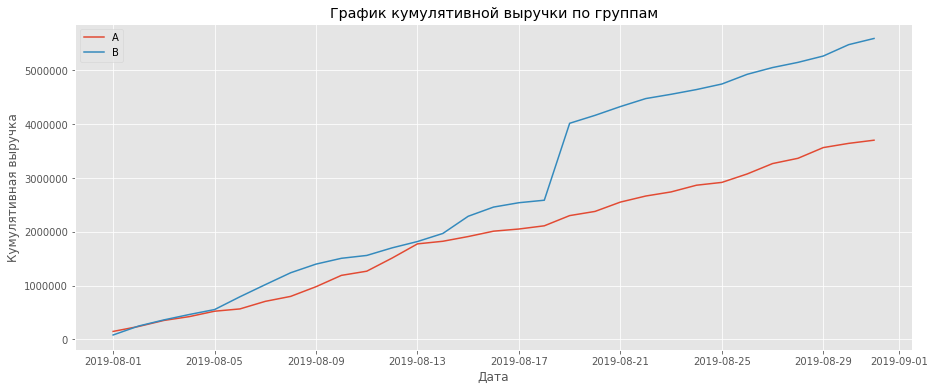

In [18]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

fig, ax = plt.subplots(figsize=(15, 6))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

ax.set_ylabel('Кумулятивная выручка')
ax.set_xlabel('Дата')
ax.set(title='График кумулятивной выручки по группам')

plt.legend()

## Вывод

Было оценено распределение пользователей между группами, и 35 пользователей по результатам теста оказались в обеих группах. Скорее всего тест был проведён некорретно или это появилось в связи с особенностью определения юзера системами аналитики ресурса. На данном этапе этих пользователей решено исключить, чтобы они не искажали данные. Разница между количество посетителей допустимая в 1%. По кумулятивной выручке видно, что группа B к окончанию теста заметно вырывается вперёд.

### 2. Какой кумулятивный средний чек по группам ? <a id="step22"></a>

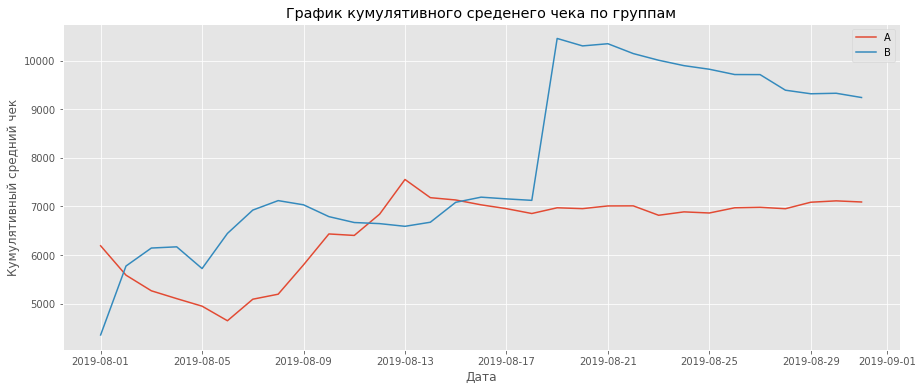

In [19]:
# Строим график для кумулятивного среднего чека по группам
fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
ax.set_ylabel('Кумулятивный средний чек')
ax.set_xlabel('Дата')
ax.set(title='График кумулятивного среденего чека по группам')
plt.legend()

## Вывод

Изучив данные на графике видим, что в начале теста также были колебания, однако к его завершению группа B существенно преобладаем по среднему чеку.

### 3. Какое относительное изменение кумулятивного среднего чека группы B к группе A<a id="step23"></a>

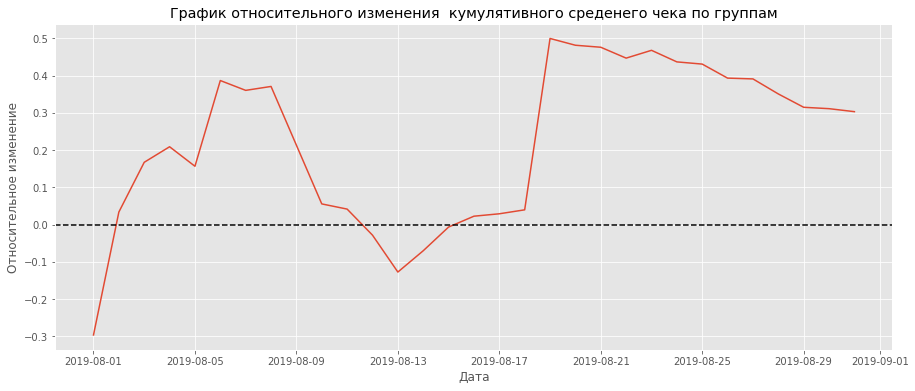

In [20]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
ax.set_ylabel('Относительное изменение')
ax.set_xlabel('Дата')
ax.set(title='График относительного изменения  кумулятивного среденего чека по группам')

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

### Вывод

Здесь видим, что на большей части теста группа B существенно преобладаем по относительному изменению кумулятивного среднего чека над группой A. К концу данные также стабилизировались.

### 4. Какая кумулятивная конверсия по группам ? <a id="step24"></a>

[Text(0.5, 1.0, 'График кумулятивной конверсии по группам')]

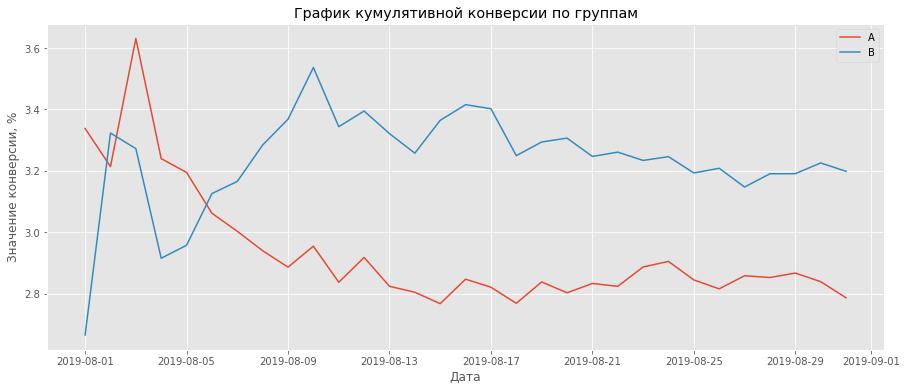

In [21]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']*100/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
ax.set_ylabel('Значение конверсии, %')
ax.set_xlabel('Дата')
ax.set(title='График кумулятивной конверсии по группам')


### Вывод

По графику кумулятивной конверсии также видим обозначившуюся динамику. Группа B лидирует по всем показателям.

### 5. Какое относительное изменение кумулятивной конверсии группы B к группе A ?<a id="step25"></a>

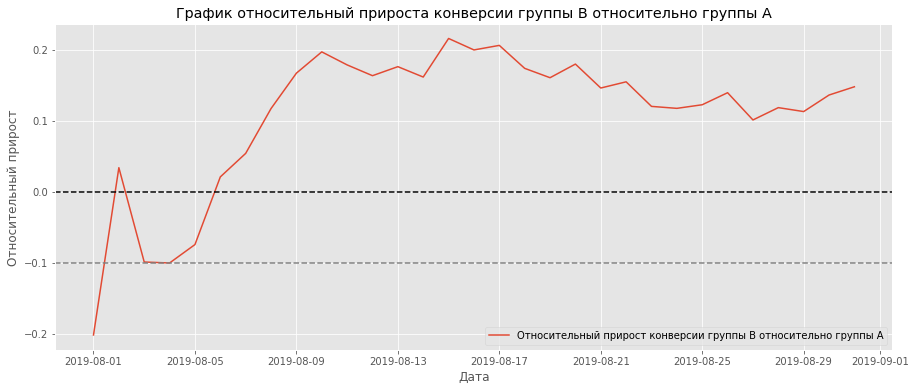

In [22]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
ax.set_ylabel('Относительный прирост')
ax.set_xlabel('Дата')
ax.set(title='График относительный прироста конверсии группы B относительно группы A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')


### Вывод

Аналогичная ситуация и при изучении относительного изменения.

### 6. Точечный график количества заказов по пользователям<a id="step26"></a>

In [23]:
ordersByUsers = orders_final.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})

ordersByUsers.columns = ['userid','orders']

display(ordersByUsers.sort_values(by='orders',ascending=False).head(10))

,userid,orders
989,4256040402,11
577,2458001652,11
555,2378935119,9
473,2038680547,8
721,3062433592,5
43,199603092,5
291,1230306981,5
890,3803269165,5
53,237748145,5
871,3717692402,5


[Text(0.5, 1.0, 'График распределения количество заказов')]

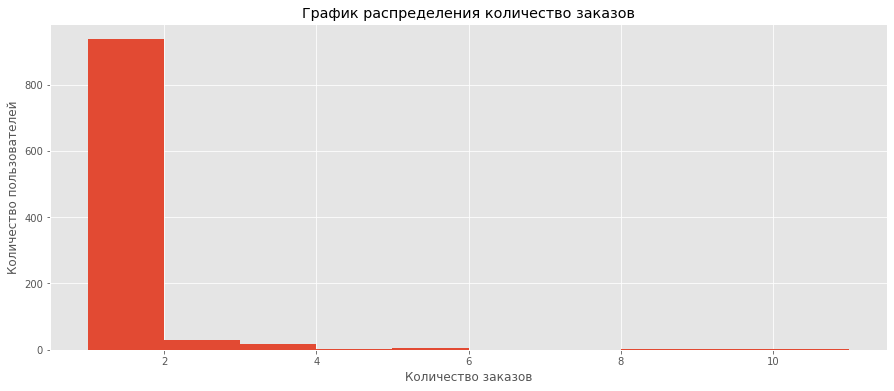

In [24]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.hist(ordersByUsers['orders'])
ax.set_ylabel('Количество пользователей')
ax.set_xlabel('Количество заказов')
ax.set(title='График распределения количество заказов')

[Text(0.5, 1.0, 'Диаграмма рассеивания количества заказов')]

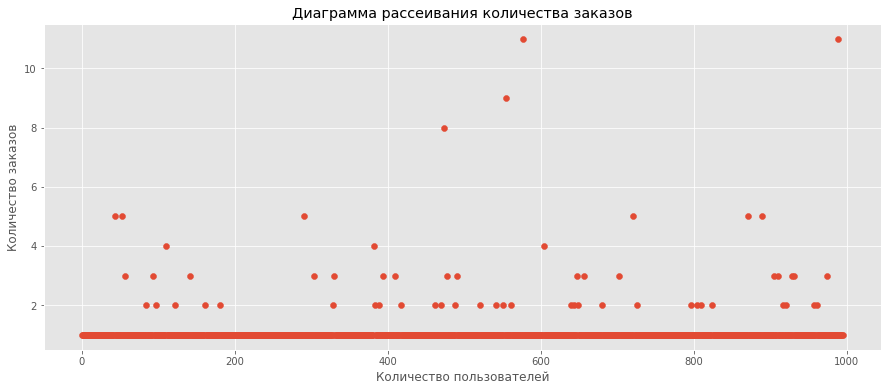

In [25]:
x_values = pd.Series(range(0,len(ordersByUsers)))
fig, ax = plt.subplots(figsize=(15, 6))
plt.scatter(x_values, ordersByUsers['orders'])
ax.set_ylabel('Количество заказов')
ax.set_xlabel('Количество пользователей')
ax.set(title='Диаграмма рассеивания количества заказов')

### Вывод

Здесь видим, что в данных по количеству заказов имеются выбросы. В освновном пользователи совершают по одному заказу в текущий период. 

### 7. Какая граница для определения аномальных пользователей<a id="step27"></a>

In [26]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))
ordersByUsers_percentile95 = np.percentile(ordersByUsers['orders'], 95)
ordersByUsers_percentile99 = np.percentile(ordersByUsers['orders'], 99)

[2.   4.05]


### Вывод

95% пользователей совершают не более 2-ух заказов, поэтому возьмём это число как пороговое для дальнейшей очистки данных от выбросов.

### 8. Точечный график стоимостей заказов<a id="step28"></a>

[Text(0.5, 1.0, 'График распределения выручки')]

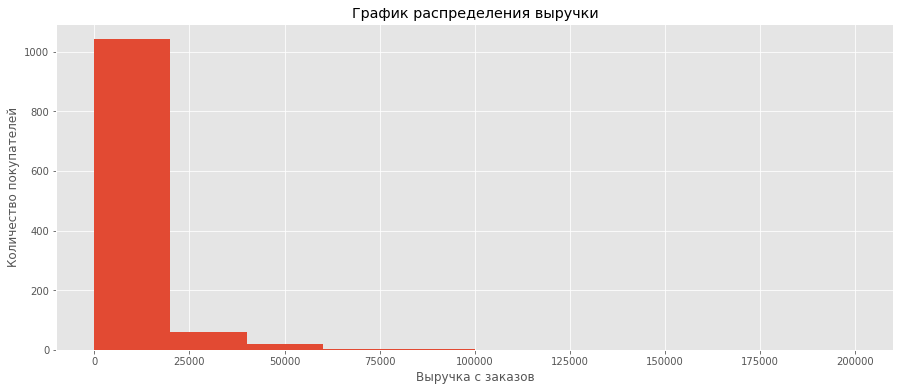

In [27]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.hist(orders_final['revenue'],range=(0,200000))
ax.set_ylabel('Количество покупателей')
ax.set_xlabel('Выручка с заказов')
ax.set(title='График распределения выручки')

[Text(0.5, 1.0, 'Диаграмма рассеивания суммарной выручки')]

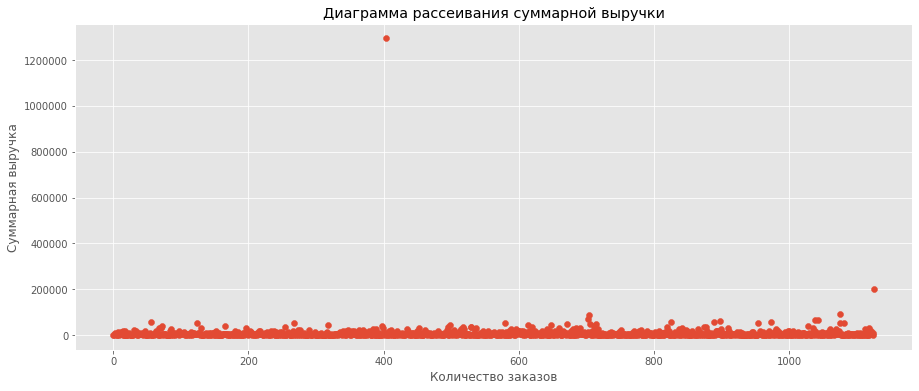

In [28]:
x_values = pd.Series(range(0,len(orders_final['revenue'])))
fig, ax = plt.subplots(figsize=(15, 6))
plt.scatter(x_values, orders_final['revenue'])
ax.set_ylabel('Суммарная выручка')
ax.set_xlabel('Количество заказов')
ax.set(title='Диаграмма рассеивания суммарной выручки')

### Вывод

Также выбросы имеются и по распределению стоимостей. Большая часть заказов лежит в диапазоне до 25 тысяч рублей.

### 9. Какая граница для определения аномальных заказов ?<a id="step29"></a>

In [29]:
print(np.percentile(orders_final['revenue'], [90, 95, 99]))

[17998.   27460.   55936.04]


In [30]:
revenue_percentile95 = np.percentile(orders_final['revenue'], 95)
revenue_percentile99 = np.percentile(orders_final['revenue'], 99)

In [31]:
orders_final.head(5)

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


### Вывод

Здесь также в качестве пограничного возьмём 95 персентиль, чтобы очистить данные от выбросов.

### 10. Какая статистическая значимость различий в конверсии между группами по «сырым» данным ?<a id="step210"></a>

In [32]:
def final_data(df):
    visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
    visitorsADaily.columns = ['date', 'visitorsPerDateA']

    visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
    visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

    visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
    visitorsBDaily.columns = ['date', 'visitorsPerDateB']

    visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
    visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


    ordersADaily = df[df['group']=='A'][['date', 'transactionid', 'visitorid', 'revenue']]\
        .groupby('date', as_index=False)\
        .agg({'visitorid' : pd.Series.nunique, 'revenue' : 'sum'})
    ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

    ordersACummulative = ordersADaily.apply(
        lambda x: \
            ordersADaily[ordersADaily['date'] <= x['date']]\
                .agg({
                    'date' : 'max',
                    'ordersPerDateA' : 'sum',
                    'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
    ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

    ordersBDaily = df[df['group']=='B'][['date', 'transactionid', 'visitorid', 'revenue']]\
        .groupby('date', as_index=False)\
        .agg({'visitorid' : pd.Series.nunique, 'revenue' : 'sum'})
    ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

    ordersBCummulative = ordersBDaily.apply(
        lambda x: \
            ordersBDaily[ordersBDaily['date'] <= x['date']]\
                .agg({
                    'date' : 'max',
                    'ordersPerDateB' : 'sum',
                    'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
    ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

    data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
        .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
        .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
        .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
        .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
        .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
        .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

    
    ordersByUsersA = df[df['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
    ordersByUsersA.columns = ['visitorid', 'orders']

    ordersByUsersB = df[df['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
    ordersByUsersB.columns = ['visitorid', 'orders']
    sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

    sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

    
    print("Критерий Манна-Уитни для различия по конверсиям групп: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
    print('')
    print("Относительный прирост конверсии группы B: {0:.3f}".format(sampleB.mean()/sampleA.mean()-1))
    

In [33]:
orders_final.pipe(final_data)

Критерий Манна-Уитни для различия по конверсиям групп: 0.007

Относительный прирост конверсии группы B: 0.148


### Вывод

Для проверки гипотезы был выбран критерий Манна-Уитни, поскольку распределение сравниваемых метрик ненормальное, он позволяет нам провести анализ данных даже при наличии выбросов. Наши распределения показателей не являются нормальными и нам важно точно оценить изменения, поэтому выбираем данный критерий. В качестве нулевой гипотезы здесь принимаем то, что группы обоих тестов идентичные и различий между ними нет. В качестве альтернативно –– обратную гипотезу о том, что конверсии на самом деле разные. Здесь мы видим, что критерий Манна-Уитни меньше 0.05. Это означает, что мы можем отвергнуть нулевую гипотезу о том, что различий между группами нет. То есть по конверсии группа B имеет конверсию на 15% больше и группы между собой различаются.

### 11. Какая статистическая значимость различий в среднем чеке между группами по «сырым» данным ?<a id="step211"></a>

In [34]:
def mannwhitneyu_mean_check(df):
    print("Критерий Манна-Уитни для различия средних чеков групп: {0:.3f}".format(stats.mannwhitneyu(df[df['group']=='A']['revenue'], df[df['group']=='B']['revenue'])[1]))
    print('')
    print("Относительный прирост среднего чека группы B: {0:.3f}".format(df[df['group']=='B']['revenue'].mean()/df[df['group']=='A']['revenue'].mean()-1))

orders_final.pipe(mannwhitneyu_mean_check)

Критерий Манна-Уитни для различия средних чеков групп: 0.339

Относительный прирост среднего чека группы B: 0.303


### Вывод

Здесь за нулевую гипотезу принимаем также то, что данные не отличаются, а в качестве альтернативной –– обратную. Однако по среднему чеку мы видим, что статистический критерий выше 0.05, что не позволяет отвергуть нулевую гипотезу о том, что различий нет. То есть мы принимаем, что средние чеки между группами не различаются.

### 12. Какая статистическая значимость различий в конверсии между группами по «очищенным» данным ? <a id="step212"></a>

In [35]:
ordersByUsers_filtered = ordersByUsers[ordersByUsers['orders'] >=ordersByUsers_percentile95]['userid']

orders_final_clear = orders_final[~orders_final.visitorid.isin(ordersByUsers_filtered)]

orders_final_clear = orders_final_clear[orders_final_clear['revenue']<=revenue_percentile95]

display(orders_final_clear)

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1190,38478481,1197745035,2019-08-14,8600,B
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A


In [36]:
orders_final_clear.pipe(final_data)

Критерий Манна-Уитни для различия по конверсиям групп: 0.008

Относительный прирост конверсии группы B: 0.173


### Вывод

Здесь за нулевую гипотезу принимаем также то, что данные обеих групп не отличаются, а в качестве альтернативной –– обратную. Для очищенных данных подтверждается информация, что конверсия группы B выше, чем конверсия группы A на 17,3%.

### 13. Какая статистическая значимость различий в среднем чеке между группами по «очищенным» данным ? <a id="step213"></a>

In [37]:
orders_final_clear.pipe(mannwhitneyu_mean_check)

Критерий Манна-Уитни для различия средних чеков групп: 0.364

Относительный прирост среднего чека группы B: -0.034


### Вывод

Здесь за нулевую гипотезу принимаем также то, что данные обеих групп не отличаются, а в качестве альтернативной –– обратную. А средние чеки всё также статистически не имеют явных различий. По очищенным данным группы B стала даже хуже, чем группа A.

## 14. Результаты теста<a id="step214"></a>

Есть статистически значимое различие по конверсии между группами как по «сырым», так и  по данным после фильтрации аномалий;
Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
График различия конверсии между группами сообщает, что результаты группы B лучше группы A и имеет некоторую тенденцию к улучшению. График различия среднего чека говорит о том, что результаты группы B ухудшаются день ото дня, хотя они и лучше группы A.

К самому разбиению на группы для тестирования гипотез есть вопросы, возможно, у нас изначально имеется проблема в данных на этом этапе, поскольку есть пользователи из 2ух групп. Но если предположить, что при их удалении данные становятся пригодными для анализа, то предлагаю тест завершить и признать его неуспешным. Конверсия в покупку действительно у группы B выше, чем у группы A, но стоит обратить внимание на средний чек, поскольку он влияет на конечные показатели по ROI. Думаю, стоит поискать ещё оптимальное изменение, которое позволит увеличить оба эти показателя как конверсию, так и средний чек.